## Post-Thesis Analysis
1. For each comparison log, what percentage of queries (deduplicated) are exactly the same as those contained in the AQL (once case-sensitive, once case-insensitive)?
2. What percentage of all queries (deduplicated) are exactly the same as those contained in at least one of the comparison logs (case-sensitive/case-insensitive)?
3. Regarding the experiments from 1., what is the situation per year? (The year(s) in which the respective comparison log was crawled is particularly interesting.)

In [90]:
from pathlib import Path
import json
from model import AnalysisName, DatasetName
from typing import Iterable, Dict, Any

def load_results(analysis_name: AnalysisName, dataset_name: DatasetName) -> Iterable[Dict[str, Any]]:
    results_folder = f"{dataset_name}-{analysis_name}"
    if analysis_name in ['count-deduplicated-queries', 'count-deduplicated-lowercase-queries']:
        path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/results")
    else:
        results_folder += "-all"
        path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/")
    
    path = path.joinpath(results_folder)
    assert path.exists(), f"Path {path} does not exist."
    # check if files inside path are json or jsonl and load accordingly
    files = []
    files.extend([file for file in path.glob("*.jsonl")])
    files.extend([file for file in path.glob("*.json")])
    if not files or all(file.suffix not in [".jsonl", ".json"] for file in files):
        raise ValueError(f"No JSON or JSONL files found in the specified path. Files found: {[file for file in path.glob('*')]}")
    data_list = []
    if files[0].suffix == ".jsonl":
        for file in files:
            with file.open("r") as f:
                data = f.readlines()
                for line in data:
                    if line.strip():
                        line = json.loads(line.strip())
                        data_list.append(line)   
    elif files[0].suffix == ".json":
        for file in files:
            with file.open("r") as f:
                data_list.append(json.load(f))
    else: 
        raise ValueError("Unsupported file format")
    return data_list

# analysis_name = "count-regular"
# analysis_name = "count-lowercase"
# analysis_name = "count-deduplicated-queries"
analysis_name = "count-deduplicated-lowercase-queries"

data_list = []
dataset_name = ['aql-aol', 'aql-ms-marco', 'aql-orcas']

if analysis_name == "count-deduplicated-lowercase-queries" or analysis_name == "count-deduplicated-queries":
    dataset_name.append('aql-aol-ms-marco-orcas')

for dataset in dataset_name:
    data = load_results(analysis_name, dataset)
    data_list.extend(data)

print(data_list)

[{'analysis_name': 'count-deduplicated-lowercase-queries', 'dataset_name': ['aql', 'aol'], 'intersec_ratio': 0.05568430826838744}, {'analysis_name': 'count-deduplicated-lowercase-queries', 'dataset_name': ['aql', 'ms-marco'], 'intersec_ratio': 0.05261392004884819}, {'analysis_name': 'count-deduplicated-lowercase-queries', 'dataset_name': ['aql', 'orcas'], 'intersec_ratio': 0.12608218844945485}, {'analysis_name': 'count-deduplicated-lowercase-queries', 'dataset_name': ['aql', 'aol', 'ms-marco', 'orcas'], 'intersec_ratio_aql': 0.029074670429790436, 'intersec_ratio_comb': 0.06403966674242968}]


In [92]:
specific_overlap = 'aql-aol'
specific_overlap = 'aql-ms-marco'
specific_overlap = 'aql-orcas'

# preprocess
result_dict = {}
if analysis_name == "count-deduplicated-lowercase-queries" or analysis_name == "count-deduplicated-queries":
    for i,data in enumerate(data_list):
        if i < len(data_list) - 1:
            result_dict[data['dataset_name'][1]] = data['intersec_ratio']
        if i == len(data_list) - 1:
            result_dict['combined'] = data['intersec_ratio_comb']
            # result_dict['aql_in_combined'] = data['intersec_ratio_aql']
else:
    datasets = []
    for i,data in enumerate(data_list):
        if data['dataset'] not in datasets:
            result_dict[data['dataset']] = {}
            datasets.append(data['dataset'])
        if data['year'] >= 1999:
            result_dict[data['dataset']][data['year']] = [data['duplicate-ratio-aql'][0], data['duplicate-ratio-comp'][0]]
    
print(result_dict)

{'aol': 0.05568430826838744, 'ms-marco': 0.05261392004884819, 'orcas': 0.12608218844945485, 'combined': 0.06403966674242968}


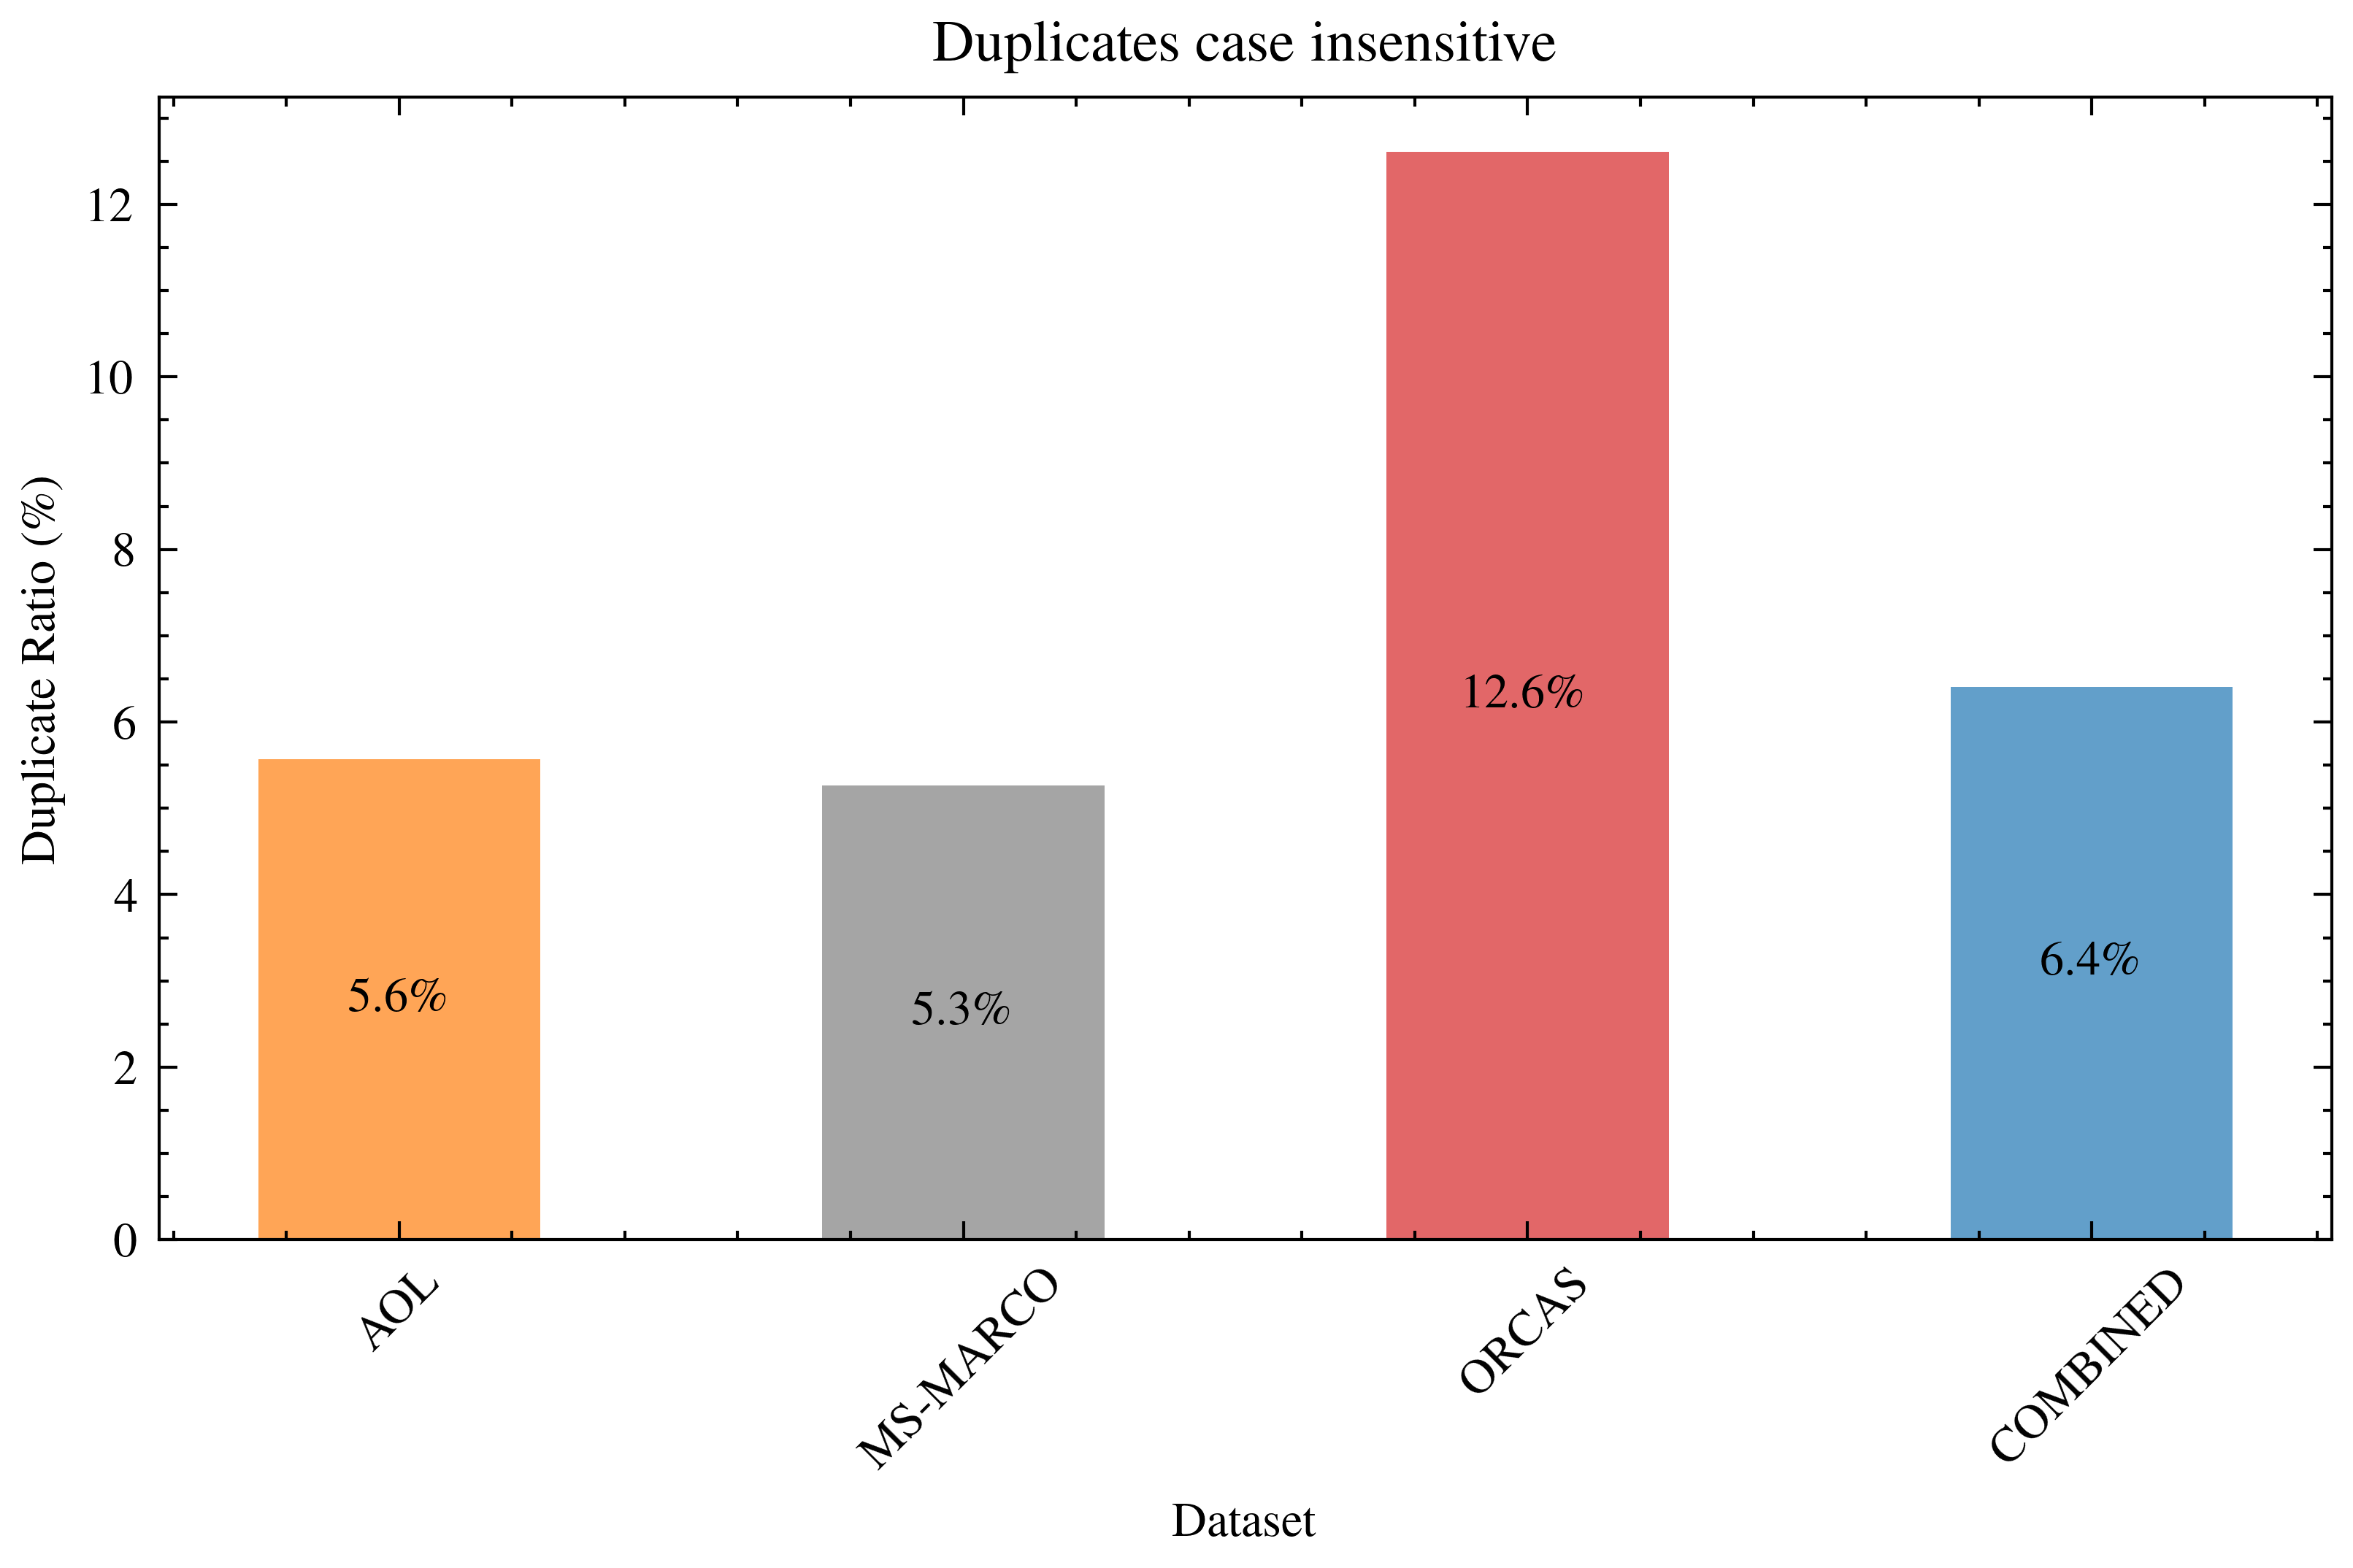

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
plt.style.use(['science', 'ieee'])

TITLE = ["Duplicates case sensitive", "Duplicates case insensitive", "Duplicates case sensitive per year", "Duplicates case insensitive per year"]
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1
width = textwidth * scale
height = width * aspect_ratio * 0.9
bar_width = 0.5 

if analysis_name == "count-deduplicated-lowercase-queries" or analysis_name == "count-deduplicated-queries":
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(width, height))
    ax.set_title(TITLE[0]) if analysis_name == "count-deduplicated-queries" else ax.set_title(TITLE[1])
    ax.set_xlabel("Dataset")
    ax.set_ylabel(r'Duplicate Ratio (\%)')  # LaTeX escape for percent sign
    # Convert values to percent
    percent_values = [v * 100 for v in result_dict.values()]
    
    # Assign specific colors to each dataset
    dataset_colors = []
    for key in result_dict.keys():
        if 'aol' in key:
            dataset_colors.append('tab:orange')
        elif 'ms-marco' in key:
            dataset_colors.append('tab:gray')
        elif 'orcas' in key:
            dataset_colors.append('tab:red')
        elif 'combined' in key:
            dataset_colors.append('tab:blue')
        else:
            dataset_colors.append('tab:blue')  # default
    
    bars = ax.bar([k.upper() for k in result_dict.keys()], percent_values, color=dataset_colors, width=bar_width, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, percent_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                rf'{value:.1f}\%', ha='center', va='center', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    pass